<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/5_BurgersEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
 ! pip install pyDOE #Latin Hypercube Sampling

ERROR: Invalid requirement: '#Latin'

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\jppan\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

import optuna
import logging
import sys


#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


C:\Users\jppan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tunning Parameters

In [3]:
# steps=10000
# lr=1e-1
# layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
N_u = 100 #Total number of data points for 'u'
N_f = 10_000 #Total number of collocation points 
nu = 0.01/np.pi #diffusion coeficient

# Auxiliary Functions


In [4]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [5]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [6]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)   

# Problem Setup
https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

**Burgers' Equation**

$$\frac{\partial u}{\partial t}+ u\frac{\partial u}{\partial x}=\nu\frac{\partial^2 u}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$

## Initial and Boundary Conditions:

Given as a matrix (We will extract them from the reference solution) 

# Analysis:
## PDE

Let:

$u_t=\frac{\partial u}{\partial t}$

$u_x=\frac{\partial u}{\partial x}$

$u_{xx}=\frac{\partial^2 u}{\partial x^2}$

So:

$$u_t+u(u_x)=\nu u_{xx}$$

If we rearrange our PDE, we get:

$$u_t+u(u_x)-\nu u_{xx}=0$$

## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset(known data).
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$NN(x,t)\approx u(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\frac{\partial^2 NN}{\partial x^2}$.(Automatic Diferentiation) 

Assume:$$NN(t,x)\approx u(t,x)$$ 

Then:

$$\frac{\partial NN}{\partial t}+N(\frac{\partial NN}{\partial x})-\nu\frac{\partial^2 NN}{\partial x^2}\approx u_t+u(u_x)-\nu u_{xx}=0$$

And:

$$\frac{\partial NN}{\partial t}+N(\frac{\partial NN}{\partial x})-\nu\frac{\partial^2 NN}{\partial x^2}\approx 0$$


We define this function as $f$:

$$f(t,x)=\frac{\partial NN}{\partial t}+N(\frac{\partial NN}{\partial x})-\nu\frac{\partial^2 NN}{\partial x^2}$$

If $f\rightarrow 0$ then our NN would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_f$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN(t_{u}^i,x_u^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

### Neural Network

In [7]:
class FCN(nn.Module):
    
    def __init__(self,layers, optimizer=None):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        self.layers = layers
        self.optimizer = optimizer
        print(f"Layers: {layers}")
        print(f"Number of linears: {len(self.linears)}")

    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            gain = nn.init.calculate_gain('tanh')
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling

        
        #convert to float
        a = x.float()
        # print("forwarding", self.layers);

        
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, X_train_Nf):
                        
        g = X_train_Nf.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([X_train_Nf.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(X_train_Nf.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,X_train_Nf):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(X_train_Nf)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        if self.optimizer is None:
            raise ValueError("Optimizer not set. Please set optimizer before calling closure.")
        
        self.optimizer.zero_grad()
        
        loss = self.loss(X_train_Nu, U_train_Nu, X_train_Nf)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = self.test()
        
            print(loss,error_vec)

        return loss 

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    
    'test neural network'
    def test(self):
                
        u_pred = self.forward(X_test)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
        
        u_pred = np.reshape(u_pred,(256,100),order='F')
                
        return error_vec, u_pred

# Generate data

C:\Users\jppan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


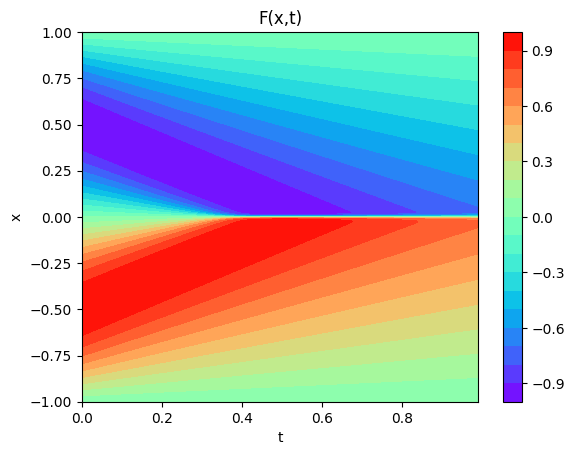

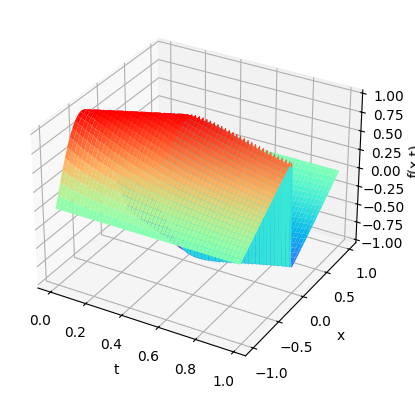

In [8]:
data = scipy.io.loadmat('../../Data/Burgers.mat') 
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) #f_real was defined previously(function)

In [9]:
print(x.shape,t.shape,usol.shape)
print(X.shape,T.shape)

(256, 1) (100, 1) (256, 100)
(100, 256) (100, 256)


## Prepare Data

In [10]:
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_test[0]  # [-1. 0.]
ub = X_test[-1] # [1.  0.99]
u_true = usol.flatten('F')[:,None] #Fortran style (Column Major)

In [11]:
print(lb,ub)

[-1.  0.] [1.   0.99]


## Training Data

In [12]:
'''Boundary Conditions'''

#Initial Condition -1 =< x =<1 and t = 0  
left_X = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
left_U = usol[:,0][:,None]

#Boundary Condition x = -1 and 0 =< t =<1
bottom_X = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
bottom_U = usol[-1,:][:,None]

#Boundary Condition x = 1 and 0 =< t =<1
top_X = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
top_U = usol[0,:][:,None]

X_train = np.vstack([left_X, bottom_X, top_X]) 
U_train = np.vstack([left_U, bottom_U, top_U]) 

#choose random N_u points for training
idx = np.random.choice(X_train.shape[0], N_u, replace=False) 

X_train_Nu = X_train[idx, :] #choose indices from  set 'idx' (x,t)
U_train_Nu = U_train[idx,:]      #choose corresponding u

'''Collocation Points'''

# Latin Hypercube sampling for collocation points 
# N_f sets of tuples(x,t)
X_train_Nf = lb + (ub-lb)*lhs(2,N_f) 
X_train_Nf = np.vstack((X_train_Nf, X_train_Nu)) # append training points to collocation points 

In [13]:
print("Original shapes for X and U:",X.shape,usol.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,U_train.shape)
print("Final training data:",X_train_Nu.shape,U_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and U: (100, 256) (256, 100)
Boundary shapes for the edges: (256, 2) (100, 2) (100, 2)
Available training data: (456, 2) (456, 1)
Final training data: (100, 2) (100, 1)
Total collocation points: (10100, 2)


In [14]:
def ensure_tensor(x, device):
    if not torch.is_tensor(x):
        return torch.from_numpy(x).float().to(device)
    return x.float().to(device)

# Use the function for conversions
X_train_Nf = ensure_tensor(X_train_Nf, device)
X_train_Nu = ensure_tensor(X_train_Nu, device)
U_train_Nu = ensure_tensor(U_train_Nu, device)
X_test = ensure_tensor(X_test, device)
u = ensure_tensor(u_true, device)
f_hat = torch.zeros(X_train_Nf.shape[0], 1).to(device)

# Define the objective function

def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    hidden_layers = trial.suggest_categorical('hidden_layers', [2, 3, 4, 5, 8])
    layer_width = trial.suggest_categorical('layer_width', [32, 64, 128])
    steps = trial.suggest_int("steps", 10000, 20000, step=5000)
    

    layers = [2] + [layer_width] * hidden_layers + [1]
    
    # Create PINN with optimized configuration
    PINN = FCN(layers)
    PINN.to(device)
    print(PINN)
    

    
    # L-BFGS Optimizer with trial-suggested learning rate
    optimizer = torch.optim.LBFGS(PINN.parameters(), 
                                   lr=lr, 
                                   max_iter=steps, 
                                   tolerance_grad=1e-11, 
                                   tolerance_change=1e-11, 
                                   history_size=100, 
                                   line_search_fn='strong_wolfe')

    PINN.set_optimizer(optimizer)
    
    # Training
    start_time = time.time()
    optimizer.step(PINN.closure)
    elapsed = time.time() - start_time
    print('Training time: %.2f' % (elapsed))
    
    error_vec, _ = PINN.test()
    print('Test Error: %.5f' % (error_vec))
    
    return error_vec.item()
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value (Test Error): {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-11-22 12:41:26,981] A new study created in memory with name: no-name-4d6f72c9-a93a-4353-bca1-10c3b9952c93


Layers: [2, 64, 64, 64, 64, 1]
Number of linears: 5
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
tensor(0.1989, grad_fn=<AddBackward0>) tensor(0.8722, grad_fn=<DivBackward0>)
tensor(0.0884, grad_fn=<AddBackward0>) tensor(0.5805, grad_fn=<DivBackward0>)
tensor(0.0714, grad_fn=<AddBackward0>) tensor(0.5759, grad_fn=<DivBackward0>)
tensor(0.0631, grad_fn=<AddBackward0>) tensor(0.5403, grad_fn=<DivBackward0>)
tensor(0.0542, grad_fn=<AddBackward0>) tensor(0.5532, grad_fn=<DivBackward0>)
tensor(0.0449, grad_fn=<AddBackward0>) tensor(0.5308, grad_fn=<DivBackward0>)
tensor(0.0414, grad_fn=<AddBackward0>) tensor(0.5379, grad_fn=<DivBackward0>)
tensor(0.0389, grad_fn=<AddBackward0>) tensor(0.5439, grad_fn=<DivBackward0>)
tensor(0.0374, grad_fn=<AddBackward0>) tensor(0.5398

[I 2024-11-22 12:53:07,156] Trial 0 finished with value: 0.2113245129585266 and parameters: {'lr': 0.0058850474564523395, 'hidden_layers': 4, 'layer_width': 64, 'steps': 20000}. Best is trial 0 with value: 0.2113245129585266.


Training time: 697.74
Test Error: 0.21132
Layers: [2, 32, 32, 32, 1]
Number of linears: 4
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1-2): 2 x Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
tensor(0.2063, grad_fn=<AddBackward0>) tensor(0.8968, grad_fn=<DivBackward0>)
tensor(0.1782, grad_fn=<AddBackward0>) tensor(0.8775, grad_fn=<DivBackward0>)
tensor(0.0886, grad_fn=<AddBackward0>) tensor(0.5861, grad_fn=<DivBackward0>)
tensor(0.0701, grad_fn=<AddBackward0>) tensor(0.5550, grad_fn=<DivBackward0>)
tensor(0.0592, grad_fn=<AddBackward0>) tensor(0.5176, grad_fn=<DivBackward0>)
tensor(0.0508, grad_fn=<AddBackward0>) tensor(0.4891, grad_fn=<DivBackward0>)
tensor(0.0451, grad_fn=<AddBackward0>) tensor(0.5182, grad_fn=<DivBackward0>)
tensor(0.0417, grad_fn=<AddBackward0>) tensor(0.5034, grad_fn=<DivBackward0>)
tensor(0.0403,

[I 2024-11-22 12:58:32,495] Trial 1 finished with value: 0.10576435923576355 and parameters: {'lr': 0.0029058174627773783, 'hidden_layers': 3, 'layer_width': 32, 'steps': 10000}. Best is trial 1 with value: 0.10576435923576355.


Training time: 325.33
Test Error: 0.10576
Layers: [2, 32, 32, 32, 1]
Number of linears: 4
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1-2): 2 x Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
tensor(0.2063, grad_fn=<AddBackward0>) tensor(0.8891, grad_fn=<DivBackward0>)
tensor(0.1283, grad_fn=<AddBackward0>) tensor(0.7538, grad_fn=<DivBackward0>)
tensor(0.1059, grad_fn=<AddBackward0>) tensor(0.6356, grad_fn=<DivBackward0>)
tensor(0.0979, grad_fn=<AddBackward0>) tensor(0.6055, grad_fn=<DivBackward0>)
tensor(0.0947, grad_fn=<AddBackward0>) tensor(0.6013, grad_fn=<DivBackward0>)
tensor(0.0919, grad_fn=<AddBackward0>) tensor(0.6091, grad_fn=<DivBackward0>)
tensor(0.0903, grad_fn=<AddBackward0>) tensor(0.6021, grad_fn=<DivBackward0>)
tensor(0.0839, grad_fn=<AddBackward0>) tensor(0.5758, grad_fn=<DivBackward0>)
tensor(0.0788,

[I 2024-11-22 12:59:15,458] Trial 2 finished with value: 0.5285133123397827 and parameters: {'lr': 0.0003211529113942442, 'hidden_layers': 3, 'layer_width': 32, 'steps': 20000}. Best is trial 1 with value: 0.10576435923576355.


Training time: 42.95
Test Error: 0.52851
Layers: [2, 128, 128, 128, 128, 128, 1]
Number of linears: 6
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1-4): 4 x Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)
tensor(0.2066, grad_fn=<AddBackward0>) tensor(0.8946, grad_fn=<DivBackward0>)
tensor(0.1710, grad_fn=<AddBackward0>) tensor(0.8649, grad_fn=<DivBackward0>)
tensor(0.0915, grad_fn=<AddBackward0>) tensor(0.5899, grad_fn=<DivBackward0>)
tensor(0.0805, grad_fn=<AddBackward0>) tensor(0.5864, grad_fn=<DivBackward0>)
tensor(0.0713, grad_fn=<AddBackward0>) tensor(0.5667, grad_fn=<DivBackward0>)
tensor(0.0598, grad_fn=<AddBackward0>) tensor(0.5147, grad_fn=<DivBackward0>)
tensor(0.0532, grad_fn=<AddBackward0>) tensor(0.4954, grad_fn=<DivBackward0>)
tensor(0.0488, grad_fn=<AddBackward0>) tensor(0.4802, grad_fn=<DivBackward0>

[I 2024-11-22 13:28:06,292] Trial 3 finished with value: 0.0945543423295021 and parameters: {'lr': 0.008902839921056825, 'hidden_layers': 5, 'layer_width': 128, 'steps': 15000}. Best is trial 3 with value: 0.0945543423295021.


Training time: 1730.78
Test Error: 0.09455
Layers: [2, 128, 128, 128, 128, 128, 1]
Number of linears: 6
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1-4): 4 x Linear(in_features=128, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)


[I 2024-11-22 13:28:33,758] Trial 4 finished with value: 0.8861863613128662 and parameters: {'lr': 0.001006009479327266, 'hidden_layers': 5, 'layer_width': 128, 'steps': 15000}. Best is trial 3 with value: 0.0945543423295021.


Training time: 27.42
Test Error: 0.88619
Layers: [2, 64, 64, 64, 64, 64, 64, 64, 64, 1]
Number of linears: 9
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-7): 7 x Linear(in_features=64, out_features=64, bias=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
tensor(0.2038, grad_fn=<AddBackward0>) tensor(0.8987, grad_fn=<DivBackward0>)
tensor(0.1100, grad_fn=<AddBackward0>) tensor(0.6509, grad_fn=<DivBackward0>)
tensor(0.0893, grad_fn=<AddBackward0>) tensor(0.5929, grad_fn=<DivBackward0>)
tensor(0.0717, grad_fn=<AddBackward0>) tensor(0.5767, grad_fn=<DivBackward0>)
tensor(0.0597, grad_fn=<AddBackward0>) tensor(0.5370, grad_fn=<DivBackward0>)
tensor(0.0516, grad_fn=<AddBackward0>) tensor(0.5167, grad_fn=<DivBackward0>)
tensor(0.0454, grad_fn=<AddBackward0>) tensor(0.5200, grad_fn=<DivBackward0>)
tensor(0.0425, grad_fn=<AddBackward0>) tensor(0.5115, grad_fn=<DivBackwar

[I 2024-11-22 13:42:03,051] Trial 5 finished with value: 0.04625636711716652 and parameters: {'lr': 0.0018165713718897888, 'hidden_layers': 8, 'layer_width': 64, 'steps': 20000}. Best is trial 5 with value: 0.04625636711716652.


Training time: 809.26
Test Error: 0.04626
Layers: [2, 128, 128, 128, 1]
Number of linears: 4
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)
tensor(0.2082, grad_fn=<AddBackward0>) tensor(0.8896, grad_fn=<DivBackward0>)


[I 2024-11-22 13:42:27,172] Trial 6 finished with value: 0.8924415707588196 and parameters: {'lr': 0.002689166835641961, 'hidden_layers': 3, 'layer_width': 128, 'steps': 20000}. Best is trial 5 with value: 0.04625636711716652.


Training time: 24.09
Test Error: 0.89244
Layers: [2, 64, 64, 64, 64, 1]
Number of linears: 5
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
tensor(0.2065, grad_fn=<AddBackward0>) tensor(0.8913, grad_fn=<DivBackward0>)
tensor(0.1975, grad_fn=<AddBackward0>) tensor(0.9022, grad_fn=<DivBackward0>)
tensor(0.1030, grad_fn=<AddBackward0>) tensor(0.6216, grad_fn=<DivBackward0>)
tensor(0.0935, grad_fn=<AddBackward0>) tensor(0.5887, grad_fn=<DivBackward0>)
tensor(0.0766, grad_fn=<AddBackward0>) tensor(0.5578, grad_fn=<DivBackward0>)
tensor(0.0689, grad_fn=<AddBackward0>) tensor(0.5606, grad_fn=<DivBackward0>)
tensor(0.0599, grad_fn=<AddBackward0>) tensor(0.5378, grad_fn=<DivBackward0>)
tensor(0.0557, grad_fn=<AddBackward0>) tensor(0.5031, grad_fn=<DivBackward0>)
tensor(0.05

[I 2024-11-22 13:51:11,650] Trial 7 finished with value: 0.14373719692230225 and parameters: {'lr': 0.0030434160426708184, 'hidden_layers': 4, 'layer_width': 64, 'steps': 20000}. Best is trial 5 with value: 0.04625636711716652.


Training time: 524.46
Test Error: 0.14374
Layers: [2, 64, 64, 64, 64, 1]
Number of linears: 5
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
tensor(0.1981, grad_fn=<AddBackward0>) tensor(0.8679, grad_fn=<DivBackward0>)
tensor(0.0978, grad_fn=<AddBackward0>) tensor(0.6044, grad_fn=<DivBackward0>)
tensor(0.0844, grad_fn=<AddBackward0>) tensor(0.5813, grad_fn=<DivBackward0>)
tensor(0.0744, grad_fn=<AddBackward0>) tensor(0.5657, grad_fn=<DivBackward0>)
tensor(0.0595, grad_fn=<AddBackward0>) tensor(0.4951, grad_fn=<DivBackward0>)
tensor(0.0501, grad_fn=<AddBackward0>) tensor(0.4846, grad_fn=<DivBackward0>)
tensor(0.0432, grad_fn=<AddBackward0>) tensor(0.4842, grad_fn=<DivBackward0>)
tensor(0.0339, grad_fn=<AddBackward0>) tensor(0.4355, grad_fn=<DivBackward0>)
tensor(0.0

[I 2024-11-22 13:59:02,208] Trial 8 finished with value: 0.25739824771881104 and parameters: {'lr': 0.008789237256931414, 'hidden_layers': 4, 'layer_width': 64, 'steps': 10000}. Best is trial 5 with value: 0.04625636711716652.


Training time: 470.54
Test Error: 0.25740
Layers: [2, 128, 128, 128, 128, 1]
Number of linears: 5
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1-3): 3 x Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
tensor(0.2069, grad_fn=<AddBackward0>) tensor(0.8932, grad_fn=<DivBackward0>)
tensor(0.2020, grad_fn=<AddBackward0>) tensor(0.8955, grad_fn=<DivBackward0>)
tensor(0.1096, grad_fn=<AddBackward0>) tensor(0.6402, grad_fn=<DivBackward0>)
tensor(0.0813, grad_fn=<AddBackward0>) tensor(0.5842, grad_fn=<DivBackward0>)
tensor(0.0654, grad_fn=<AddBackward0>) tensor(0.5611, grad_fn=<DivBackward0>)
tensor(0.0587, grad_fn=<AddBackward0>) tensor(0.5239, grad_fn=<DivBackward0>)
tensor(0.0523, grad_fn=<AddBackward0>) tensor(0.5320, grad_fn=<DivBackward0>)
tensor(0.0470, grad_fn=<AddBackward0>) tensor(0.5190, grad_fn=<DivBackward0>)
te

[I 2024-11-22 14:30:52,664] Trial 9 finished with value: 0.10302699357271194 and parameters: {'lr': 0.004659740395609525, 'hidden_layers': 4, 'layer_width': 128, 'steps': 15000}. Best is trial 5 with value: 0.04625636711716652.


Training time: 1910.40
Test Error: 0.10303
Best trial:
  Value (Test Error): 0.04625636711716652
  Params: 
    lr: 0.0018165713718897888
    hidden_layers: 8
    layer_width: 64
    steps: 20000


# Train Neural Network

In [15]:
best_layers = [2]
best_layers.extend([trial.params['layer_width']] * trial.params['hidden_layers'])
best_layers.append(1)

final_PINN = FCN(best_layers)
final_PINN.to(device)
print(final_PINN)

best_steps = trial.params['steps']

best_optimizer = torch.optim.LBFGS(final_PINN.parameters(), 
                                    lr=trial.params['lr'], 
                                    max_iter=best_steps, 
                                    tolerance_grad=1e-11, 
                                    tolerance_change=1e-11, 
                                    history_size=100, 
                                    line_search_fn='strong_wolfe')


final_PINN.set_optimizer(best_optimizer)
start_time = time.time()
# train final model with best hyperparameters
best_optimizer.step(final_PINN.closure)
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

final_error, final_pred = final_PINN.test()

# print results
print("Best hyperparameters: ", study.best_params)
print("Best test error: ", study.best_value)
print("Final model test error: ", final_error.item())

Layers: [2, 64, 64, 64, 64, 64, 64, 64, 64, 1]
Number of linears: 9
FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-7): 7 x Linear(in_features=64, out_features=64, bias=True)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
tensor(0.2048, grad_fn=<AddBackward0>) tensor(0.9047, grad_fn=<DivBackward0>)
tensor(0.1448, grad_fn=<AddBackward0>) tensor(0.7574, grad_fn=<DivBackward0>)
tensor(0.1116, grad_fn=<AddBackward0>) tensor(0.6685, grad_fn=<DivBackward0>)
tensor(0.0946, grad_fn=<AddBackward0>) tensor(0.5884, grad_fn=<DivBackward0>)
tensor(0.0823, grad_fn=<AddBackward0>) tensor(0.5699, grad_fn=<DivBackward0>)
tensor(0.0657, grad_fn=<AddBackward0>) tensor(0.5282, grad_fn=<DivBackward0>)
tensor(0.0541, grad_fn=<AddBackward0>) tensor(0.5070, grad_fn=<DivBackward0>)
tensor(0.0460, grad_fn=<AddBackward0>) tensor(0.4889, grad_fn=<DivBackward0>)
tensor(0.0391, grad_fn=<AddBackward0

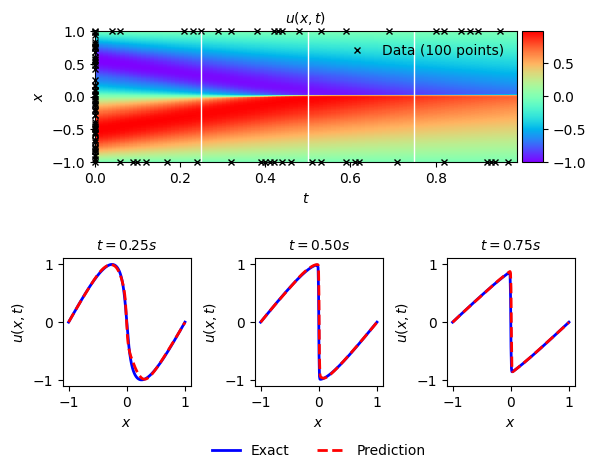

In [17]:
solutionplot(final_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

### Plots

In [18]:
x1=X_test[:,0]
t1=X_test[:,1]

In [19]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_y1=final_pred
arr_y_test=usol

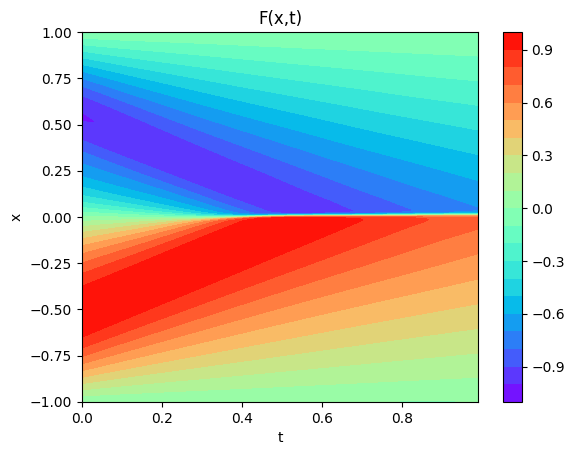

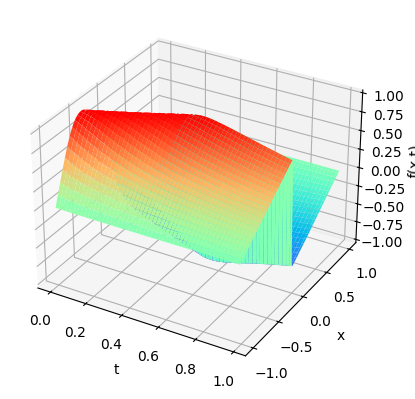

In [20]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(arr_y1))

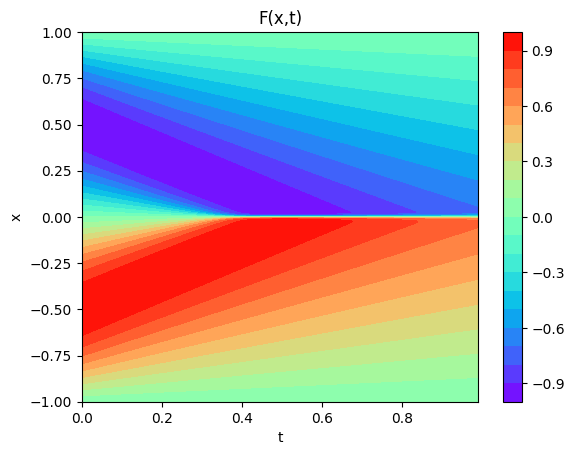

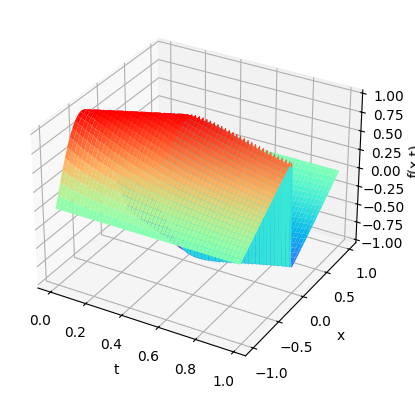

In [21]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol))

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
